In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from torch import nn
from easy_tpp.preprocess.event_tokenizer import EventTokenizer
from easy_tpp.config_factory import DataSpecConfig
from models.encoders.gru import GRUTPPEncoder
from models.decoders.rmtpp import RMTPPDecoder, RMTPPLoss
from models import TPPModel, VAETPPModel
from torch.utils.data import DataLoader, Dataset
from utils.evaluatetpp import evaluate_tpp_model, evaluate_vae_model, calculate_event_metrics
from scipy import integrate

In [2]:
def preprocess_data(raw_data):
    # Validate input
    if not raw_data:
        raise ValueError("Input data is empty")
        
    # Create input data dictionary
    input_data = {
        'time_seqs': [[x["time_since_start"] for x in seq] for seq in raw_data],
        'type_seqs': [[x["type_event"] for x in seq] for seq in raw_data],
        'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in raw_data]
    }

    filtered_data = {
        k: [seq for seq in v if len(seq) > 0]
        for k, v in input_data.items()
    }
    
    if not filtered_data['type_seqs']:
        raise ValueError("No valid sequences found after filtering (all sequences were empty)")
        
    return filtered_data

def collate_fn(batch, config):
    tokenizer = EventTokenizer(config)
    tokenizer.padding_side = 'right'
    seq_lengths = [batch_item['sequence_length'] for batch_item in batch]  
    padded_batch = tokenizer.pad(batch, 
                                 return_tensors='pt',
                                 return_attention_mask=None,
                                 padding='longest')
    padded_batch['sequence_length'] = torch.tensor(seq_lengths)
    
    return padded_batch

In [3]:
class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['type_seqs'])

    def __getitem__(self, idx):
        return {
            'time_seqs': self.data['time_seqs'][idx],
            'type_seqs': self.data['type_seqs'][idx],
            'time_delta_seqs': self.data['time_delta_seqs'][idx],
            'sequence_length': len(self.data['type_seqs'][idx])
        }

In [4]:
def plot_event_sequence(time_seqs, type_seqs, time_delta_seqs, sequence_length, calculated_deltas, decoder_output, num_samples=5):
    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()
        pred_time_delta_seq = calculated_deltas[i].detach().cpu().numpy() if calculated_deltas is torch.Tensor else calculated_deltas
        pred_mark_logits = decoder_output.mark_logits[i].detach().cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(time_seq[:seq_len], type_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], np.argmax(pred_mark_logits[:seq_len], axis=-1), 'o-', label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Event Type')
        plt.title('Event Sequence')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(time_seq[:seq_len], time_delta_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], pred_time_delta_seq[:seq_len], 'o-', label='Calculated')
        plt.xlabel('Time')
        plt.ylabel('Time Delta')
        plt.title('Time Delta Sequence')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [5]:
dev_dict = pkl.load(open('data/taxi/dev.pkl', 'rb'))
test_dict = pkl.load(open('data/taxi/test.pkl', 'rb'))
train_dict = pkl.load(open('data/taxi/train.pkl', 'rb'))

train_data = train_dict['train']
test_data = test_dict['test']
dev_data = dev_dict['dev']

In [6]:
dim_process = train_dict['dim_process']
config = DataSpecConfig.parse_from_yaml_config({
    'num_event_types': dim_process,
    'pad_token_id': dim_process
})

In [7]:
# Create datasets
preprocessed_train = preprocess_data(train_data)
preprocessed_test = preprocess_data(test_data)

train_dataset = EventDataset(preprocessed_train)
test_dataset = EventDataset(preprocessed_test)

# Create data loaders with collate function and arguments to prepare_data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)

In [16]:
HIDDEN_DIM = 128
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

tpp_model = TPPModel(config, hidden_dim=HIDDEN_DIM, mlp_dim=MLP_DIM, device=device).to(device)

# Training loop
num_epochs = 200
optimizer = torch.optim.Adam(tpp_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    tpp_model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        decoder_output = tpp_model(batch)
        time_loss, mark_loss, total_loss = tpp_model.compute_loss(batch, decoder_output)
        total_loss.backward()
        optimizer.step()
        total_train_loss += total_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Evaluate on test data
    tpp_model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            decoder_output = tpp_model(batch)
            _, _, total_loss = tpp_model.compute_loss(batch, decoder_output)
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

Epoch 1/200, Train Loss: 1.1072
Epoch 1/200, Test Loss: 0.6126
Epoch 2/200, Train Loss: 0.4714
Epoch 2/200, Test Loss: 0.2326
Epoch 3/200, Train Loss: 0.0684
Epoch 3/200, Test Loss: -0.1067
Epoch 4/200, Train Loss: -0.2548
Epoch 4/200, Test Loss: -0.4063
Epoch 5/200, Train Loss: -0.4647
Epoch 5/200, Test Loss: -0.5730
Epoch 6/200, Train Loss: -0.6231
Epoch 6/200, Test Loss: -0.7343
Epoch 7/200, Train Loss: -0.7591
Epoch 7/200, Test Loss: -0.8545
Epoch 8/200, Train Loss: -0.8665
Epoch 8/200, Test Loss: -0.9464
Epoch 9/200, Train Loss: -0.9316
Epoch 9/200, Test Loss: -0.9940
Epoch 10/200, Train Loss: -0.9963
Epoch 10/200, Test Loss: -1.0511
Epoch 11/200, Train Loss: -1.0340
Epoch 11/200, Test Loss: -1.0772
Epoch 12/200, Train Loss: -1.0636
Epoch 12/200, Test Loss: -1.1071
Epoch 13/200, Train Loss: -1.0903
Epoch 13/200, Test Loss: -1.1167
Epoch 14/200, Train Loss: -1.1209
Epoch 14/200, Test Loss: -1.1618
Epoch 15/200, Train Loss: -1.1488
Epoch 15/200, Test Loss: -1.1852
Epoch 16/200, Trai

In [17]:
tpp_eval_metrics = evaluate_tpp_model(tpp_model, test_loader, config, device=device)

/Users/heqingyin/Desktop/ProbabilisticTPP/utils/evaluatetpp.py:96: RuntimeWarning: overflow encountered in exp
  - np.exp(
/Users/heqingyin/Desktop/ProbabilisticTPP/utils/evaluatetpp.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_next_time = integrate.quad(


In [18]:
tpp_eval_metrics

{'time_mae': np.float32(0.029095206),
 'time_rmse': np.float32(0.038251743),
 'event_accuracy': np.float64(0.9997975708502024),
 'event_total': 14820,
 'type_metrics': {'type_0': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_1': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_2': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_3': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_4': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_5': {'precision': np.float64(0.9982014388489209),
   'recall': np.float64(1.0),
   'f1': np.float64(0.9990999099909991)},
  'type_6': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_7': {'precision': np.float64(0.75),
   'recall': np.float64(1.0),
   'f1': np.float64(0.8571428

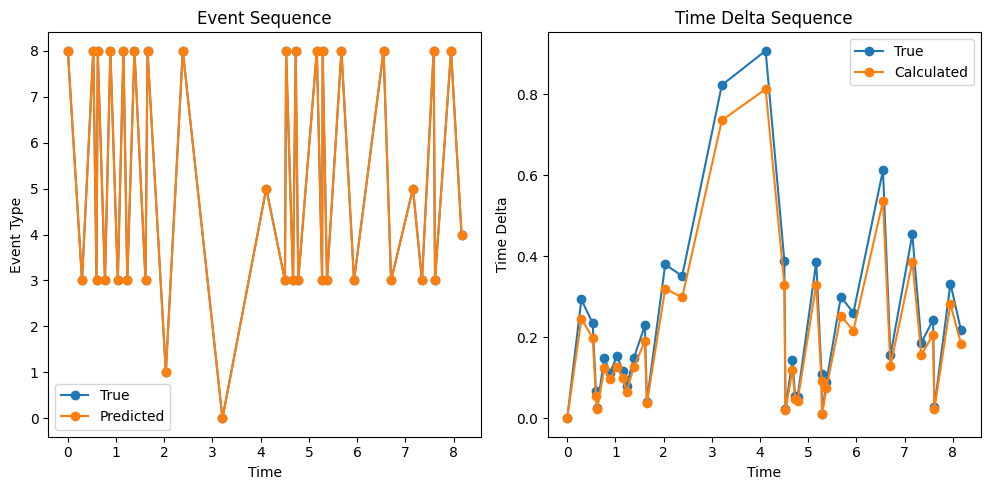

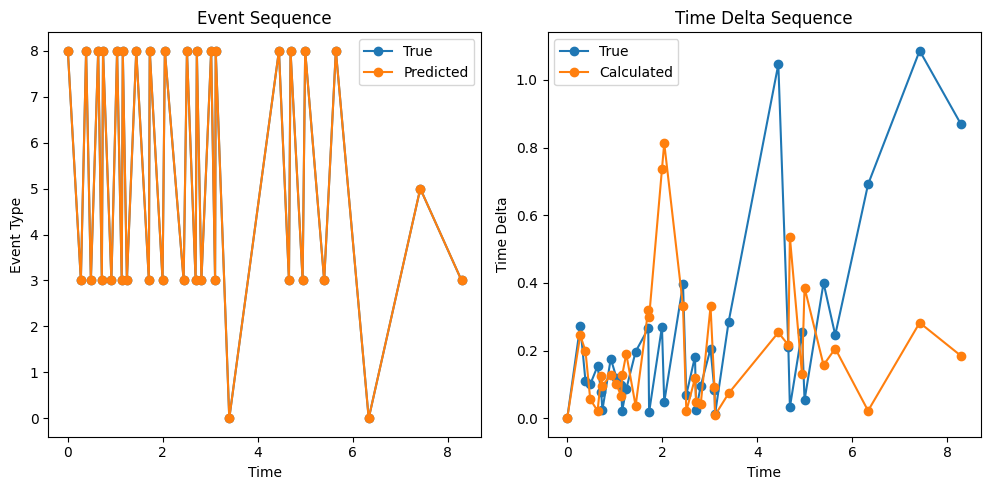

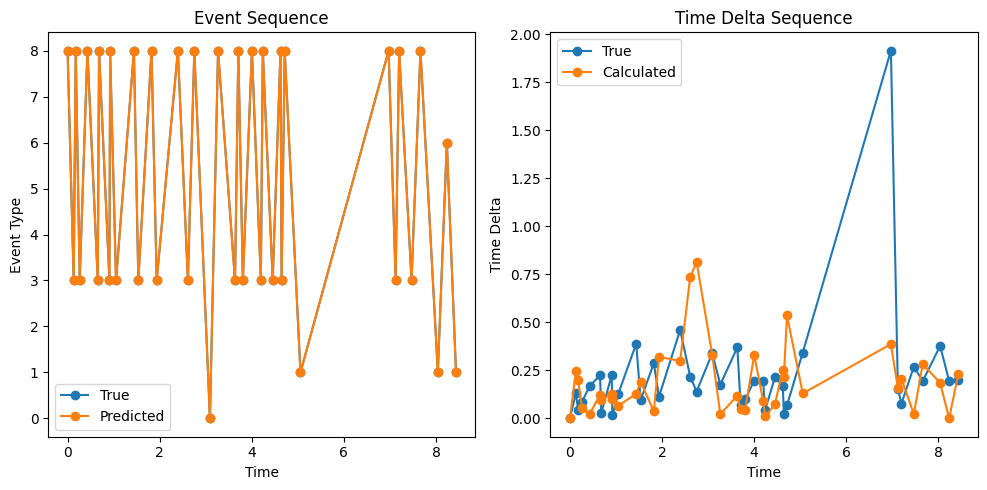

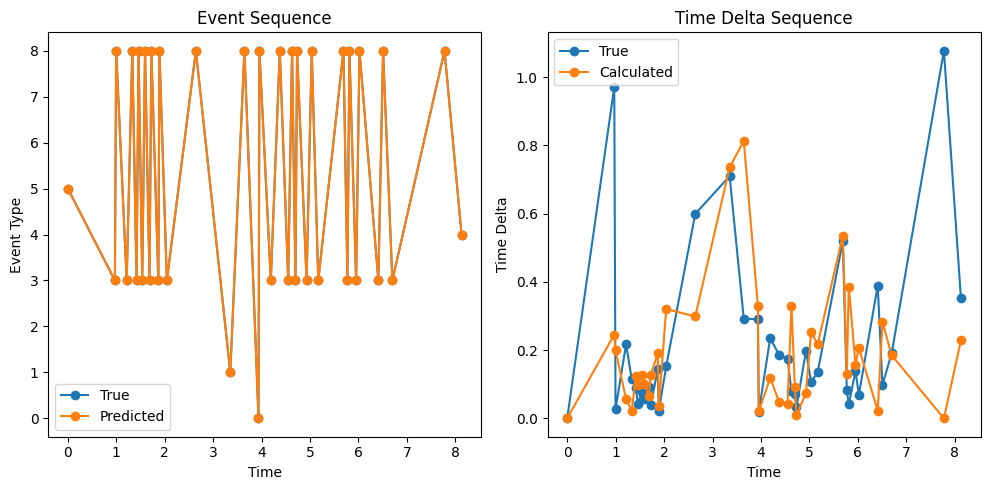

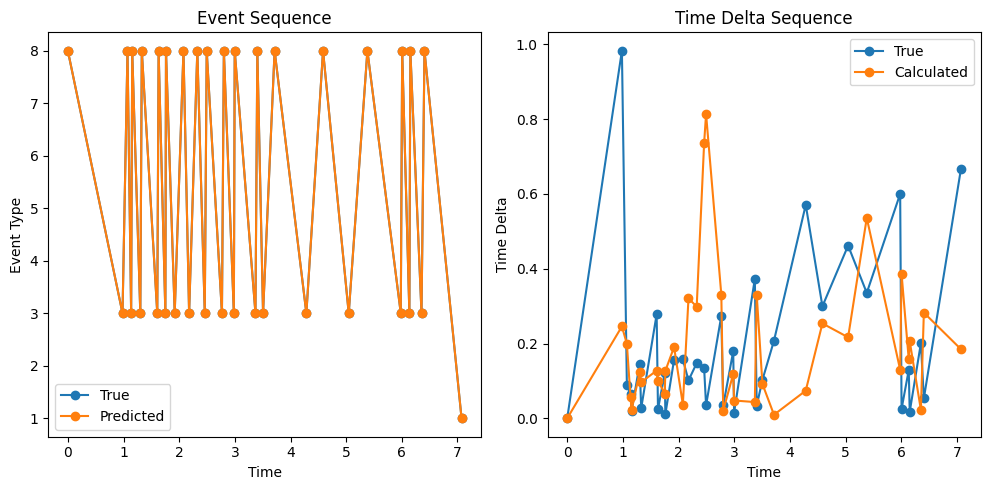

In [19]:
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = tpp_model(batch)
    plot_event_sequence(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        tpp_eval_metrics['predicted_intervals'], 
        decoder_output
    )
    break

In [13]:
HIDDEN_DIM = 128
LATENT_DIM = 32
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

vae_model = VAETPPModel(config, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, mlp_dim=MLP_DIM, device=device).to(device)

num_epochs = 200
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    vae_model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        decoder_output = vae_model(batch)
        time_loss, mark_loss, total_loss = vae_model.compute_loss(batch, decoder_output)
        total_loss.backward()
        optimizer.step()
        total_train_loss += total_loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    vae_model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            decoder_output = vae_model(batch)
            _, _, total_loss = vae_model.compute_loss(batch, decoder_output)
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

Epoch 1/200, Train Loss: 895.5877
Epoch 1/200, Test Loss: 11.9814
Epoch 2/200, Train Loss: 10.7562
Epoch 2/200, Test Loss: 3.0011
Epoch 3/200, Train Loss: 5.1595
Epoch 3/200, Test Loss: 2.1918
Epoch 4/200, Train Loss: 3.5419
Epoch 4/200, Test Loss: 1.3515
Epoch 5/200, Train Loss: 2.6302
Epoch 5/200, Test Loss: 1.1773
Epoch 6/200, Train Loss: 2.1055
Epoch 6/200, Test Loss: 0.9470
Epoch 7/200, Train Loss: 1.8214
Epoch 7/200, Test Loss: 0.9104
Epoch 8/200, Train Loss: 1.5160
Epoch 8/200, Test Loss: 0.7395
Epoch 9/200, Train Loss: 1.4123
Epoch 9/200, Test Loss: 0.8567
Epoch 10/200, Train Loss: 1.2603
Epoch 10/200, Test Loss: 0.7203
Epoch 11/200, Train Loss: 1.1628
Epoch 11/200, Test Loss: 0.6859
Epoch 12/200, Train Loss: 1.1085
Epoch 12/200, Test Loss: 0.7215
Epoch 13/200, Train Loss: 1.0600
Epoch 13/200, Test Loss: 0.6529
Epoch 14/200, Train Loss: 1.0193
Epoch 14/200, Test Loss: 0.6938
Epoch 15/200, Train Loss: 0.9726
Epoch 15/200, Test Loss: 0.6564
Epoch 16/200, Train Loss: 0.9631
Epoch 

In [10]:
vae_eval_metrics = evaluate_vae_model(vae_model, test_loader, config, device=device)

In [11]:
# vae_eval_metrics

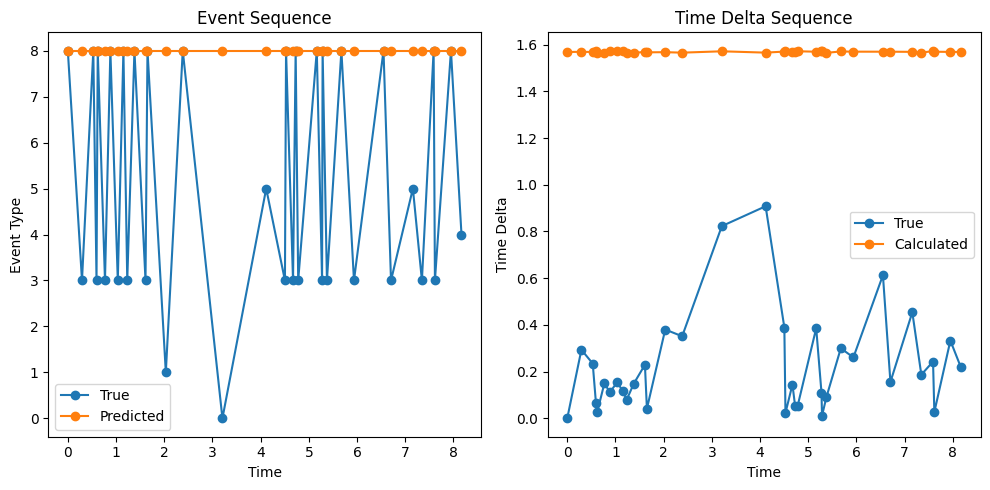

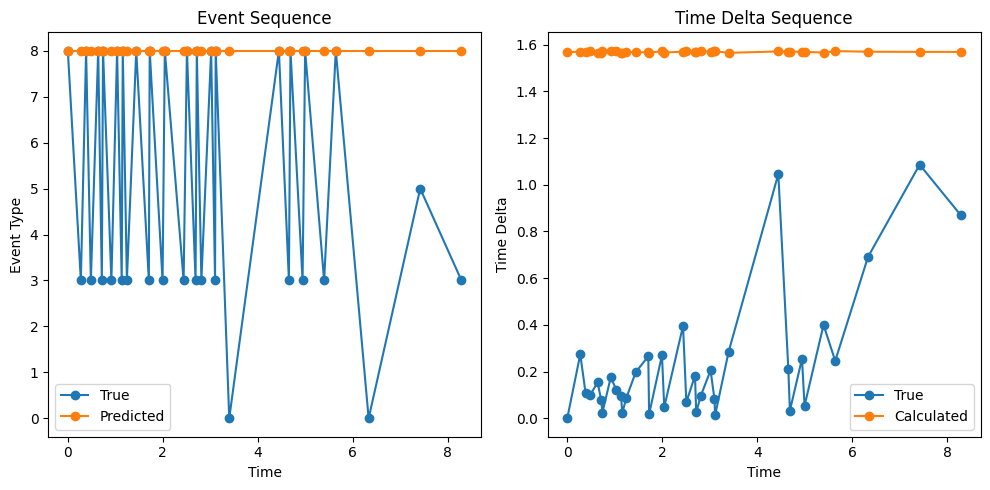

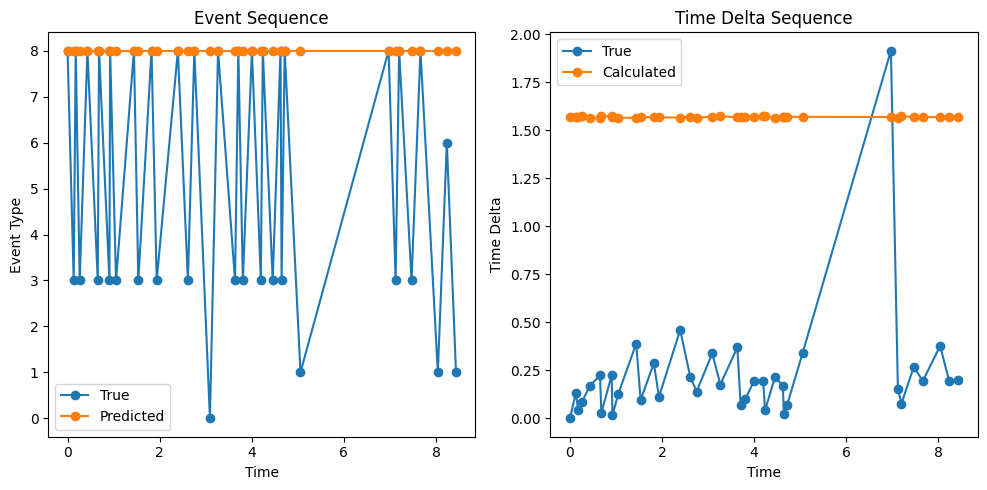

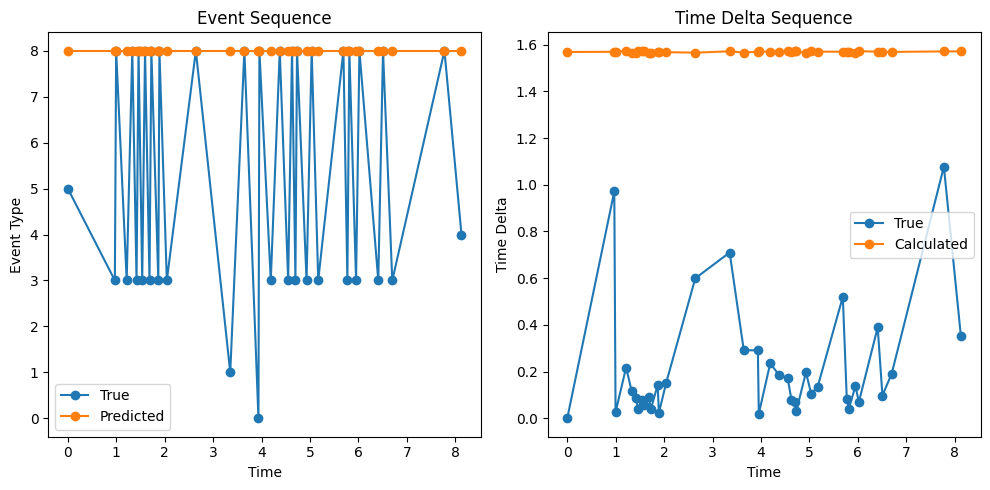

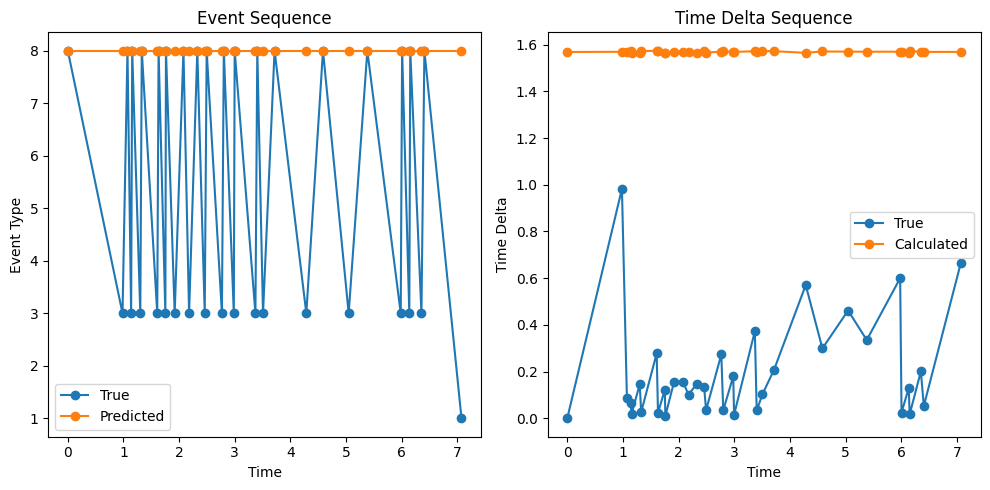

In [12]:
# plot the event sequences and the predicted event sequences
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = vae_model(batch)
    plot_event_sequence(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        vae_eval_metrics['predicted_intervals'], 
        decoder_output
    )
    break
